In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [68]:
df = pd.read_csv("flow.csv")
df = df[['Date','Value']]  
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values('Date')


df.set_index('Date', inplace=True)

df = df.dropna()

df1 = pd.read_csv("preC.csv")
df1 = df1[['Date','Value']]  
df1['Date'] = pd.to_datetime(df1['Date'])

df1 = df1.sort_values('Date')


df1.set_index('Date', inplace=True)

df1 = df1.dropna()







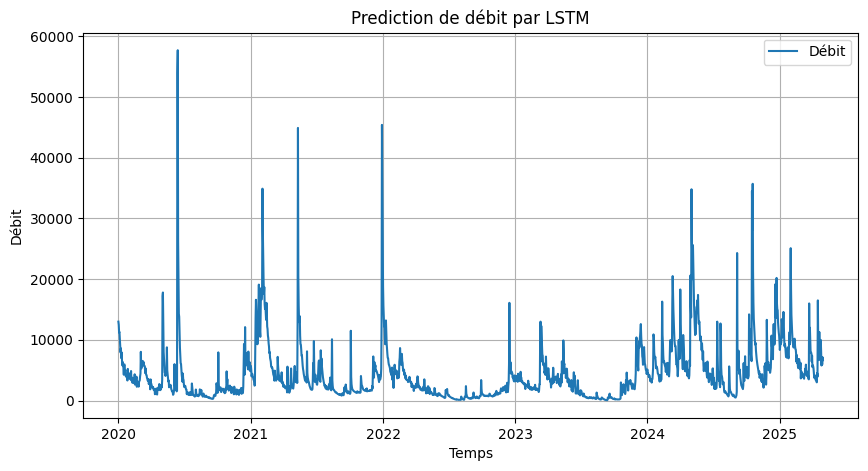

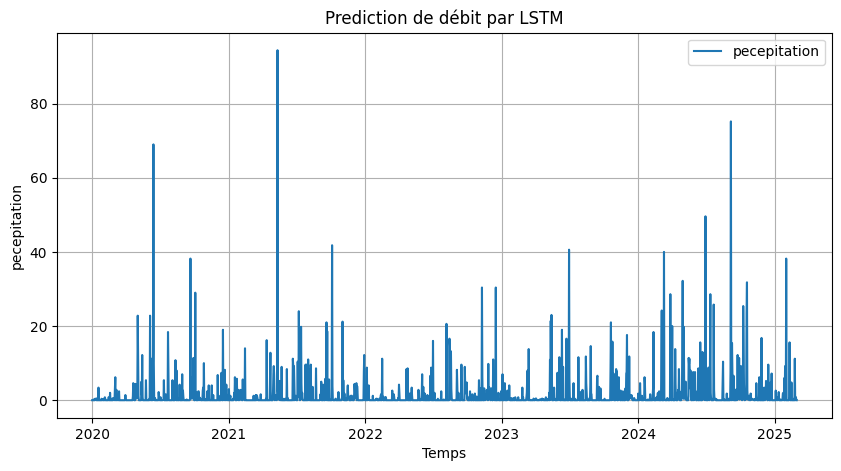

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(df, label='Débit')


plt.legend()
plt.title("Prediction de débit par LSTM")
plt.xlabel("Temps")
plt.ylabel("Débit")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(df1, label='pecepitation')

plt.legend()
plt.title("Prediction de débit par LSTM")
plt.xlabel("Temps")
plt.ylabel("pecepitation")
plt.grid(True)
plt.show()

In [75]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

scaler1 = MinMaxScaler(feature_range=(0, 1))
scaled_data1 = scaler1.fit_transform(df1)


In [79]:
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    last_30_debit = scaled_data[i-sequence_length:i].flatten()
    last_30_precip = scaled_data1[i-sequence_length:i].flatten()

    # نتأكد الطول الصحيح
    if len(last_30_debit) != sequence_length or len(last_30_precip) != sequence_length:
        continue  # نعدّيها

    # نحسب المعدلات
    mean_debit = np.mean(last_30_debit)
    mean_precip = np.mean(last_30_precip)

    # نجمّع كلهم
    features = np.concatenate([last_30_debit, last_30_precip, [mean_debit], [mean_precip]])

    X.append(features)
    y.append(scaled_data[i])

# نبدلهم إلى numpy array
X = np.array(X)
y = np.array(y)



split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(X,y)

[[0.22448342 0.21580874 0.19325457 ... 0.         0.11193231 0.0021896 ]
 [0.21580874 0.19325457 0.1949895  ... 0.00211862 0.10700509 0.00226022]
 [0.19325457 0.1949895  0.1759052  ... 0.         0.1022745  0.00226022]
 ...
 [0.14363539 0.17937508 0.1949895  ... 0.00847449 0.17149846 0.02916636]
 [0.17937508 0.1949895  0.15994379 ... 0.         0.16997172 0.0259178 ]
 [0.1949895  0.15994379 0.3424591  ... 0.         0.16693558 0.02577656]] [[0.07666684]
 [0.07389094]
 [0.06053193]
 ...
 [0.09783306]
 [0.08829091]
 [0.10685473]]


In [80]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [81]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
with tf.device('/GPU:0'):
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_train, y_train),
        callbacks=[early_stop]
    )


Epoch 1/100
47/47 [==============================] - 5s 47ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 2/100
47/47 [==============================] - 2s 36ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 3/100
47/47 [==============================] - 2s 36ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 4/100
47/47 [==============================] - 2s 36ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/100
47/47 [==============================] - 2s 37ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/100
47/47 [==============================] - 2s 39ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/100
47/47 [==============================] - 2s 37ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/100
47/47 [==============================] - 2s 36ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/100
47/47 [==============================] - 2s 40ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/100
47/47 [==============================] - 2s 44ms/step - loss: 0.0032 - val_loss: 0.0029

In [82]:
predictedd = model.predict(X_test)

12/12 [==============================] - 1s 14ms/step


In [83]:
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np

In [91]:
mse = mean_squared_error(y_test, predictedd)
r2 = r2_score(y_test, predictedd)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - predictedd))
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"r2 = {r2:.4f}")
print(f"mae = {mae:.4f}")

MSE  = 0.0055
RMSE = 0.0744
r2 = 0.4112
mae = 0.0426


In [85]:

predicted = scaler.inverse_transform(predictedd)
y_test_original = scaler.inverse_transform(y_test)
hist =  scaler.inverse_transform(y_train)


In [86]:
p = predicted
r = y_test_original

In [87]:
predicted = predicted[1:]
y_test_original = y_test_original[:-1]

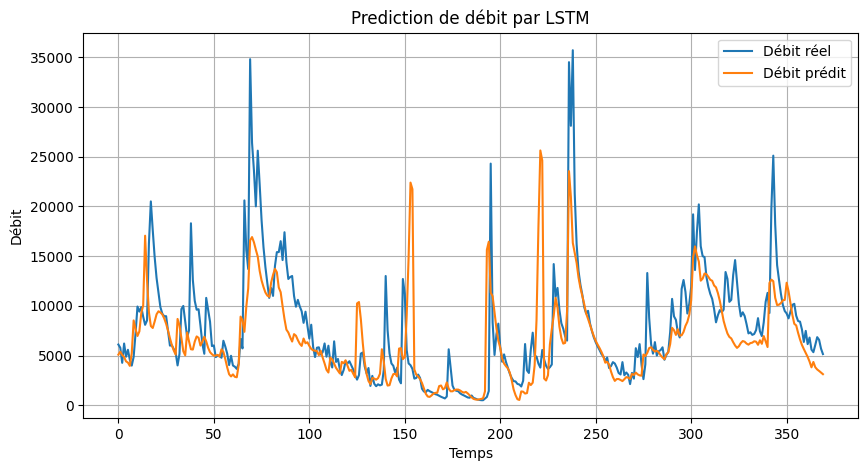

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_original, label='Débit réel')
plt.plot(predicted, label='Débit prédit')

plt.legend()
plt.title("Prediction de débit par LSTM")
plt.xlabel("Temps")
plt.ylabel("Débit")
plt.grid(True)
plt.show()
